In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
%matplotlib inline

# To be able to view all of the columns when viewing the dataset
pd.options.display.max_columns = None

/Users/jean-sebastienprovost/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/jean-sebastienprovost/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/jean-sebastienprovost/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: Th

In [2]:
class Data:
    def __init__(self, training_data, traininig_labels, testing_data, testing_labels, \
                 log_features, drop_cols, num_cols, cat_cols):
        '''create train and test dataframes'''
        self.train_feature_file = self._create_df(training_data)
        self.train_target_file = self._load_data(traininig_labels)
        self.test_feature_file = self._create_df(testing_data)
        self.test_target_file = self._load_data(testing_labels)
        self.feature_cols = cat_cols + num_cols
        self.num_cols = list(num_cols)
        self.cat_cols = list(cat_cols)
        #self.train_target_index = data.train_target_file['Unnamed: 0']
    
    def _create_df(self, df, preprocess=True, label_encode=True):
        ''' Create a preprocessed train/test set '''
        df = self._load_data(df)
        df = self._drop_cols(df, drop_cols)
        if preprocess:
            df = self.log_transform(df, log_features)
        if label_encode:
            df = self.label_encode_df(df)
        return df
    
    def label_encode_df(self, df):
        ''' creates one label encoder for each column in the data object instance'''
        df = pd.get_dummies(df)
        return df

    def _drop_cols(self, df, col):
        ''' Drop columns listed as arguments; a list of columns should be provided'''
        df = df.drop(col, axis=1)
        return df
    
    def log_transform(self, df, cols):
        ''' Perform the log transform on the listed columns provided as argument'''
        for col in cols:
            df[col] = self._log_transform(df, col)
            return df
        
    def _log_transform(self, df, col):
        ''' Perform the log transform on a column provided as argument'''
        df[col] = np.log(df[col]+1)
        return df[col]
    
    def _load_data(self, df_path):
        ''' Load the data set from csv '''
        return pd.read_csv(df_path, index_col=0)

    def resampling(self, X_train, y_train, over_ratio=None, under_ratio=None):
        ''' 
        Perform resampling according to the arguments provided.
        Need to specifify the ratio for over/under sampling to do both. 
        Otherwise, only the one with a value will be performed.
        '''
        #Both over and under sampling
        if (over_ratio != None) & (under_ratio != None):
            over = SMOTE(ratio=over_ratio)
            under = RandomUnderSampler(ratio=under_ratio)
            steps = [("o", over), ("u", under)]
            pipeline = Pipeline(steps=steps)
            X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)
            self.train_feature_file = pd.DataFrame(X_train_res)
            self.train_target_file = pd.DataFrame(y_train_res)
        #Over sampling
        elif (over_ratio != None) & (under_ratio == None):
            sm = SMOTE(ratio=over_ratio)
            X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 
            self.train_feature_file = pd.DataFrame(X_train_res)
            self.train_target_file = pd.DataFrame(y_train_res)
        else:
            # Under sampling
            sm = RandomUnderSampler(ratio=under_ratio)
            X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 
            self.train_feature_file = pd.DataFrame(X_train_res)
            self.train_target_file = pd.DataFrame(y_train_res)  
   

        
class ModelContainer:
    def __init__(self, models=[]):#, default_num_iters=10, verbose_lvl=0):
        '''initializes model list and dicts'''
        self.models = models
        self.best_model = None
        self.predictions = None
        self.metrics = {}
        #self.scoring = scoring
        #self.default_num_iters = default_num_iters
        #self.verbose_lvl = verbose_lvl

    def add_model(self, model):
        ''' Add algorithm with parameters to create a model in the later stage '''
        self.models.append(model)

    def cross_validate(self, data, k=3, num_procs=1, metrics=None):
        '''cross validate models using given data'''
        feature_df = data.train_feature_file
        target_df = data.train_target_file
        for model in self.models:
            print(model)
            self.metrics[model] = cross_val_score(model, feature_df, target_df,
                                                  cv=k, n_jobs=num_procs, scoring=metrics)
    
    def select_best_model(self):
        '''select model with highest metrics'''
        tmp_best_model = None
        tmp_best_value = 0
        for k,v in models.metrics.items():
            b_model, b_value = k,max(v)
            if tmp_best_value < b_value:
                tmp_best_value = b_value
                tmp_best_model = b_model
        self.best_model = tmp_best_model
         
    def best_model_fit(self, features, targets):
        '''fits best model'''
        self.best_model.fit(features, targets)
    
    def best_model_predict(self, features):
        '''scores features using best model'''
        self.predictions = self.best_model.predict(features)
        
    def save_results(self):
        pass
    
    @staticmethod
    def get_feature_importance(model, cols):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature':cols, 'importance':importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"
    
        
    def print_summary(self):
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:\n')
        for model in models.metrics:
            print('\n', model, '- Metrics:', models.metrics[model])
        print('\nBest Model:\n', models.best_model)
        print('\nMetrics of Best Model\n', models.metrics[models.best_model])
        print('\nFeature Importances\n', models.get_feature_importance(models.best_model, data.train_feature_file.columns))
        print('\nConfusion Matrix\n', confusion_matrix(data.test_target_file, models.predictions))
        feature_importances = self.get_feature_importance(models.best_model, data.train_feature_file.columns)
        ax = feature_importances.plot(
            kind='bar', figsize=(12,7)) 
        plt.show()
    

/Users/jean-sebastienprovost/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-sebastienprovost/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/jean-sebastienprovost/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


LogisticRegression()
RandomForestClassifier(max_depth=15, max_features=8, min_samples_split=80,
                       n_estimators=60, n_jobs=4)
GradientBoostingClassifier(max_depth=7, n_estimators=40)


<ipython-input-2-4f17cfda3276>:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_model.fit(features, targets)



Model Summaries:


 LogisticRegression() - Metrics: [0.58885755 0.60684062 0.60811287 0.60035273 0.59470899]

 RandomForestClassifier(max_depth=15, max_features=8, min_samples_split=80,
                       n_estimators=60, n_jobs=4) - Metrics: [0.55571227 0.94393512 0.9957672  0.99611993 0.99329806]

 GradientBoostingClassifier(max_depth=7, n_estimators=40) - Metrics: [0.55535966 0.94111425 0.99435626 0.99470899 0.99118166]

Best Model:
 RandomForestClassifier(max_depth=15, max_features=8, min_samples_split=80,
                       n_estimators=60, n_jobs=4)

Metrics of Best Model
 [0.55571227 0.94393512 0.9957672  0.99611993 0.99329806]

Feature Importances
          importance
feature            
17         0.087240
14         0.079837
23         0.072162
28         0.060799
11         0.051895
1          0.050621
18         0.048277
4          0.043324
13         0.038995
3          0.029906
12         0.028796
2          0.028426
35         0.026876
38         0.023351
9     

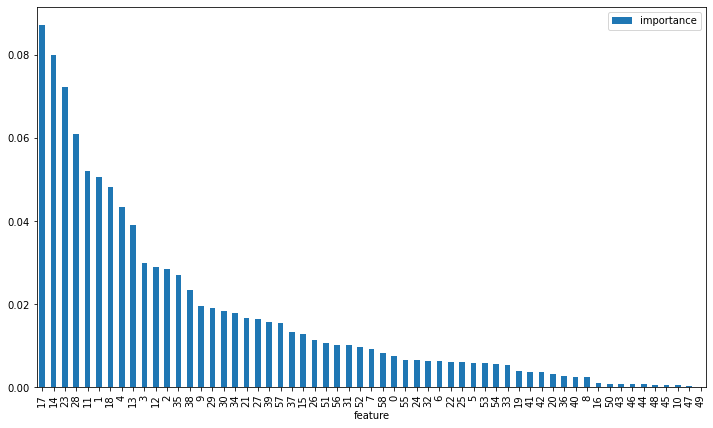

In [3]:
if __name__ == '__main__':
    
    #define number of processors to use for parallel runs
    num_procs = 4

    #set verbose level for models
    verbose_lvl = 0
    
    #metric of interest
    metric='accuracy'

    #define input files
    training_data = "data_science/X_train.csv"
    traininig_labels = "data_science/y_train.csv"
    testing_data = "data_science/X_test.csv"
    testing_labels = "data_science/y_test.csv"
    log_features = ['income', 'household_income', 'volume_transaction', 'volume_credit_card', 'volume_financing']
    
    drop_cols = ['client_id']

    #define variables
    num_cols = ['english', 'birth_last_year', 'apartment', 'nb_children', 'age', 'income', 'household_income',
                'visit the store_last_year', 'premium_membership', 'credit_card', 'web_search', 'nb_web_search',
                'membership_competitors', 'won_prize', 'required_financing', 'cash_transaction', 'nb_product_purchased',
                'customer_since_when', 'volume_credit_card', 'prize_amount', 'volume_financing', 'volume_transaction',
                'nb_electronics', 'interest_rate', 'GDP',
               ]
    cat_cols = ['education_cat', 'city_cat', 'job_title_cat', 'age_group',
               'home_revenue_group', 'revenue_group']
    target_col = 'purchased'
    id_col = 'client_id'

#     #turn feature engineering on/off
#     engineer_features = True

    #Create Data object
    data = Data(training_data, traininig_labels, testing_data, testing_labels, \
                log_features, drop_cols, num_cols, cat_cols)
    
    #Apply resampling method - upsampling the minority class
    data.resampling(data.train_feature_file, data.train_target_file, over_ratio=0.5, under_ratio=0.8)
    
    #Create model container and add models to it
    models = ModelContainer()

    #create models -- hyperparameter tuning already done by hand for each model
    models.add_model(LogisticRegression())
    models.add_model(RandomForestClassifier(n_estimators=60, n_jobs=num_procs, max_depth=15, min_samples_split=80, 
                                            max_features=8, verbose=verbose_lvl))
    models.add_model(GradientBoostingClassifier(n_estimators=40, max_depth=7, verbose=verbose_lvl))
    
    #Cross validate models, then select, fit, and score test data with best model
    models.cross_validate(data, k=5, num_procs=num_procs, metrics=metric)
    models.select_best_model()
    models.best_model_fit(data.train_feature_file, data.train_target_file)
    models.best_model_predict(data.test_feature_file)

    #Summarize results
    models.print_summary()


In [4]:
# Class performing hyperparameter tunings for the Gradient Boosting Model

class TuningGradientModel:
    
    def __init__(self, parameters, X_train, y_train, X_test, y_test, model, metrics):
        
        self.parameters = parameters
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model
        self.metrics = metrics
        best_predictions = None
        best_predictions_proba = None
        self.best_clf = None

    def tuning_model(self):
    # fbeta_score scoring object using make_scorer()
        if self.metrics == 'f1_score':    
            scorer = make_scorer(f1_score)
        elif self.metrics == 'accuracy':
            scorer = make_scorer(accuracy_score)
            
        # Grid Search on the classifier using 'scorer' as the scoring method
        grid_obj = GridSearchCV(self.model, param_grid=self.parameters, scoring=scorer)

        # Fit the grid search object to the training data and find the optimal parameters using fit()
        grid_fit = grid_obj.fit(self.X_train, self.y_train)

        # Get the estimator
        self.best_clf = grid_fit.best_estimator_

        # Make predictions using the unoptimized and model
        self.best_predictions = self.best_clf.predict(self.X_test)
        self.best_predictions_proba = self.best_clf.predict_proba(self.X_test) 
        
        # Report the scores
        print("\nOptimized Model\n------")
        print("Final f1 score on the test data: {:.4f}".format(accuracy_score(self.y_test, self.best_predictions)))
        print('\nConfusion Matrix\n', confusion_matrix(data.test_target_file, self.best_predictions))
        print(self.best_clf)
    
    @staticmethod
    def get_feature_importance(model, cols):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature':cols, 'importance':importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"
    
        
    def print_summary(self):
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:\n')
        print('\nBest Model:\n', self.best_clf)
        print('\nFeature Importances\n', models.get_feature_importance(self.best_clf, data.train_feature_file.columns))
        print('\nConfusion Matrix\n', confusion_matrix(data.test_target_file, self.best_predictions))
        feature_importances = self.get_feature_importance(self.best_clf, data.train_feature_file.columns)
        ax = feature_importances.plot(
            kind='bar', figsize=(12,7)) 
        plt.show()

/Users/jean-sebastienprovost/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jean-sebastienprovost/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jean-sebastienprovost/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jean-sebastienprovost/opt/anaconda3/lib


Optimized Model
------
Final f1 score on the test data: 0.8993

Confusion Matrix
 [[5396    6]
 [ 599    4]]
RandomForestClassifier(max_depth=7, max_features=8, min_samples_split=7,
                       n_estimators=150, n_jobs=4, random_state=42)

Model Summaries:


Best Model:
 RandomForestClassifier(max_depth=7, max_features=8, min_samples_split=7,
                       n_estimators=150, n_jobs=4, random_state=42)

Feature Importances
          importance
feature            
17         0.100187
23         0.093748
14         0.087503
1          0.080258
28         0.054792
18         0.052471
11         0.048399
2          0.038036
35         0.036204
4          0.036028
13         0.035615
38         0.029493
3          0.027943
9          0.027773
37         0.020362
39         0.018331
21         0.016548
56         0.016536
12         0.016088
29         0.013093
57         0.012917
34         0.012004
51         0.011959
15         0.010589
27         0.010385
52         0.

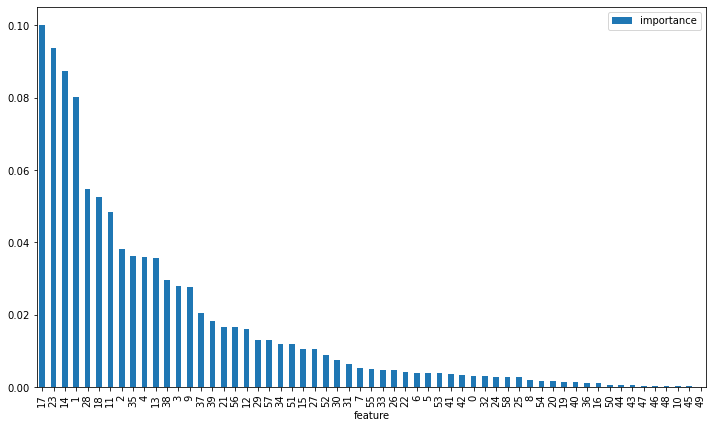

In [5]:
# List of hyperparameters to perform gridsearch with
parameters = {"n_estimators": [150], 
              "max_depth": [7], 
              "learning_rate": [0.01, 0.1, 1],
              "min_samples_split": [7],
              "random_state": [42]}


# Tuning of the model
final_model = TuningGradientModel(parameters, 
                                  data.train_feature_file, 
                                  data.train_target_file, 
                                  data.test_feature_file, 
                                  data.test_target_file, 
                                  models.best_model, 
                                  'accuracy')

# Printing the final result
final_model.tuning_model()
final_model.print_summary()